# Using `ncbi.datasets` library to download and parse genome annotation data in GFF3 format

The objective of this notebook is to use the `ncbi.datasets` python library to demonstrate how to download and parse genome annotation data in gff3 format from NCBI Datasets.

There are two major types of genome data available from NCBI Datasets:

1. Genome datasets, which include genome, transcript, and protein sequences, genome annotation data in gff3 format, an assembly data report (genome assembly and annotation metadata) and a sequence report (a list of sequences that comprise the genome assembly).  

2. Genome summaries, which are sets of key metadata that describe the genome datasets 

As an example, we will download gff3 files for five _Lactobacillus_ genome assemblies, then parse those gff3 files to get information about crispr gene order in the corresponding genome assemblies.

The notebook can be broken down into the following four major tasks:
1. Query NCBI for _Lactobacillus_ assemblies and download the genome summaries for all available genome assemblies
2. Parse the genome summaries to make a list of genome assemblies annotated in 2020
3. Download sequence and annotation (gff3 and protein fasta) for five of those assemblies
4. Parse the gff3 files to look at crispr gene order in those assemblies

## Setup
After importing the various python modules we will need, create the assembly and download API instances.

In [1]:
from collections import defaultdict, Counter
from datetime import datetime
import json
import os
from textwrap import dedent
import zipfile

import gffutils
import matplotlib.pyplot as plt
import ncbi.datasets
import pandas as pd
from pyfaidx import Fasta

plt.style.use('ggplot')

genome_api = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

## Group genome assemblies based on annotation date
Let's look at RefSeq *lactobacillus* genome assemblies, and see how we can group them based on annotation date. Annotation date, when available, is described in the genome summary.

This section will include the following two major tasks:
1. Query NCBI for Lactobacillus assemblies and download the genome summaries for all available genome assemblies
2. Make a list of genome assemblies annotated in 2020

Using the `ncbi.datasets` library, let's first get the count of available RefSeq *lactobacillus* assemblies. By setting `limit='none'`, we tell the API to return a genome summary with only the count of genome assemblies for the specified NCBI Taxonomy ID.

In [1]:
taxid = '1578' ## This is the NCBI Taxonomy ID for lactobacillus
genome_summary = genome_api.assembly_descriptors_by_taxon(
    taxon=taxid,
    page_size=1,
    filters_assembly_source='refseq')

print(f"Number of RefSeq lactobacillus genome assemblies: {genome_summary.total_count}")

Number of RefSeq lactobacillus genome assemblies: 1060


Now let's download the genome summaries for these genome assemblies.

In [1]:
## download the genome summaries for all RefSeq lactobacillus genome assemblies
genome_summary = genome_api.assembly_descriptors_by_taxon(
    taxon=taxid,
    page_size=1000,
    filters_assembly_source='refseq')
print(f"Genome summaries for {genome_summary.total_count} genome assemblies downloaded and saved to genome_summary.")
print(f"As an example, here's the first genome summary for the first genome assembly in the list:\n", genome_summary.assemblies[0])

Genome summaries for 1060 genome assemblies downloaded and saved to genome_summary.
As an example, here's the first genome summary for the first genome assembly in the list:
 {'assembly': {'annotation_metadata': {'file': [{'estimated_size': '111943',
                                                'type': 'GENOME_GFF'},
                                               {'estimated_size': '1187873',
                                                'type': 'GENOME_GBFF'},
                                               {'estimated_size': '301643',
                                                'type': 'PROT_FASTA'},
                                               {'estimated_size': '126907',
                                                'type': 'GENOME_GTF'}],
                                      'name': 'From INSDC submitter',
                                      'release_date': '2019-10-07',
                                      'source': 'Korea University',
                            

Next we'll plot the assemblies by the year they were annotated.


WARNING!
Some assemblies do not have annotation. 
Most likely, this is because of an indexing delay. Skipping 3 assemblies.



<AxesSubplot:>

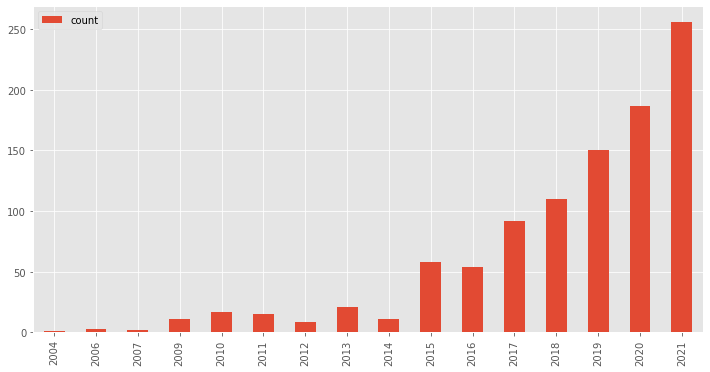

In [1]:
def annotation_year(annotation_metadata):
    return datetime.strptime(annotation_metadata.release_date, '%Y-%M-%d').year

annots_by_year = Counter()
no_annot_assms = []
for d in map(lambda d: d.assembly, genome_summary.assemblies):
    if not d.annotation_metadata:
        no_annot_assms.append(d.assembly_accession)
        continue
    annots_by_year[annotation_year(d.annotation_metadata)] += 1


if len(no_annot_assms) > 0:
    print(dedent(f'''
    WARNING!
    Some assemblies do not have annotation. 
    Most likely, this is because of an indexing delay. Skipping {len(no_annot_assms)} assemblies.
'''))

df = pd.DataFrame.from_dict(annots_by_year, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(12,6))

We can make a list of the genome assemblies that were annotated in 2020 and count the number of genomes in the list.

In [1]:
year_of_interest = 2020
genome_accessions = []
for d in map(lambda d: d.assembly, genome_summary.assemblies):
    if d.annotation_metadata:
        if annotation_year(d.annotation_metadata) == year_of_interest:
            genome_accessions.append(d.assembly_accession)
        
print(f'{len(genome_accessions)} genome assemblies were annotated in {year_of_interest}.')
print(f"Here are the first five genome assemblies in the list: {genome_accessions[0:5]}")

187 genome assemblies were annotated in 2020.
Here are the first five genome assemblies in the list: ['GCF_012848655.1', 'GCF_014648715.1', 'GCF_013342945.1', 'GCF_013867555.1', 'GCF_013867605.1']


We could download genome datasets for all of the returned assemblies, based on the accessions stored in `genome_accessions`.  If there are quite a few of them, a `download_api.download_assembly_package_post()` request would be required (see docs here)[https://github.com/ncbi/datasets/blob/master/client_docs/python/docs/DownloadApi.md#download_assembly_package_post]. 

For demonstration purposes, we'll just download genome datasets for five genome assemblies through a GET request.

In [1]:
%%time
## Download data
# Let's use accessions #21-25 in the list because these all have at least one crispr gene
print(f'Download genome datasets for 5 accessions: {genome_accessions[20:25]}')
dl_response = genome_api.download_assembly_package(
    accessions=genome_accessions[20:25],
    exclude_sequence=False,
    include_annotation_type=['GENOME_GFF', 'PROT_FASTA'],
    _preload_content=False )

## write to a zip file 
zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(dl_response.data)
print(f'Download saved to {zipfn}')
!unzip -l {zipfn}

Download genome datasets for 5 accessions: ['GCF_013778545.1', 'GCF_014654865.1', 'GCF_014982905.1', 'GCF_015669875.1', 'GCF_015708055.1']
Download saved to ncbi_genomes.zip
Archive:  ncbi_genomes.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
      661  07-16-2021 15:02   README.md
     6167  07-16-2021 15:02   ncbi_dataset/data/assembly_data_report.jsonl
  2323408  07-16-2021 15:02   ncbi_dataset/data/GCF_013778545.1/GCF_013778545.1_ASM1377854v1_genomic.fna
  1242442  07-16-2021 15:02   ncbi_dataset/data/GCF_013778545.1/genomic.gff
   765683  07-16-2021 15:02   ncbi_dataset/data/GCF_013778545.1/protein.faa
  2094903  07-16-2021 15:02   ncbi_dataset/data/GCF_014654865.1/GCF_014654865.1_Biofab_BC5_1.1_genomic.fna
  1129307  07-16-2021 15:02   ncbi_dataset/data/GCF_014654865.1/genomic.gff
   732940  07-16-2021 15:02   ncbi_dataset/data/GCF_014654865.1/protein.faa
  1965961  07-16-2021 15:02   ncbi_dataset/data/GCF_014982905.1/GCF_014982905.1_ASM1498290v1_genom

Next, we're going to look for crispr genes in these genome datasets, and extract the corresponding crispr gene and protein sequences.  
We're going to break this down into a few steps.  
First, let's make a list of the data files that are available for each genome assembly. We can use the `dataset_catalog.json` file to tell us which data files are available for each genome assembly.

In [1]:
## function to make list of files 
from ncbi.datasets.v1 import catalog_pb2
import pprint
pp = pprint.PrettyPrinter(indent=4)

def retrieve_data_catalog(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip:
        data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))
    print(f"Catalog found with metadata for {len(data_catalog['assemblies'])-1} assemblies")
    return data_catalog

def get_assemblies(data_catalog):
    return [x['accession'] for x in data_catalog['assemblies'] if 'accession' in x]

# Temporary hack to support GENOMIC_NUCLEOTIDE_FASTA & PROTEIN_FASTA 
# which will be present in the next release
def get_file_list(data_catalog, desired_filetype):
    desired_filetype = desired_filetype.upper()
    if desired_filetype not in catalog_pb2.File.FileType.keys():
        raise Exception(f'Filetype {desired_filetype} is invalid.')
    
    files = defaultdict(list)
    for asm in data_catalog['assemblies']:
        if 'accession' in asm:
            acc = asm['accession'] 
            for f in asm['files']:
                filepath = os.path.join('ncbi_dataset', 'data', f['filePath'])
                if f['fileType'] == 'FASTA' and desired_filetype in ('GENOMIC_NUCLEOTIDE_FASTA') and filepath.endswith('fna'):
                    files[acc].append(filepath)
                    continue
                if f['fileType'] == 'GFF3':
                    if desired_filetype in ('PROTEIN_FASTA') and filepath.endswith('faa'):
                        files[acc].append(filepath)
                    if desired_filetype in ('GFF3') and filepath.endswith('gff'):
                        files[acc].append(filepath)
                    continue
                if f['fileType'] == desired_filetype:
                    files[acc].append(filepath)
        
    return files

data_catalog = retrieve_data_catalog(zipfn)
print(f'Assemblies:')
print(', '.join(get_assemblies(data_catalog)))
for file_type in ['GFF3', 'FASTA', 'GENOMIC_NUCLEOTIDE_FASTA', 'PROTEIN_FASTA']:
    file_list = get_file_list(data_catalog, file_type)
    print(f'Files for type: {file_type}')
    pp.pprint(file_list)


Catalog found with metadata for 5 assemblies
Assemblies:
GCF_013778545.1, GCF_014654865.1, GCF_014982905.1, GCF_015669875.1, GCF_015708055.1
Files for type: GFF3
defaultdict(<class 'list'>,
            {   'GCF_013778545.1': [   'ncbi_dataset/data/GCF_013778545.1/genomic.gff'],
                'GCF_014654865.1': [   'ncbi_dataset/data/GCF_014654865.1/genomic.gff'],
                'GCF_014982905.1': [   'ncbi_dataset/data/GCF_014982905.1/genomic.gff'],
                'GCF_015669875.1': [   'ncbi_dataset/data/GCF_015669875.1/genomic.gff'],
                'GCF_015708055.1': [   'ncbi_dataset/data/GCF_015708055.1/genomic.gff']})
Files for type: FASTA
defaultdict(<class 'list'>, {})
Files for type: GENOMIC_NUCLEOTIDE_FASTA
defaultdict(<class 'list'>,
            {   'GCF_013778545.1': [   'ncbi_dataset/data/GCF_013778545.1/GCF_013778545.1_ASM1377854v1_genomic.fna'],
                'GCF_014654865.1': [   'ncbi_dataset/data/GCF_014654865.1/GCF_014654865.1_Biofab_BC5_1.1_genomic.fna'],
   

We're going to create temporary files to store the genome annotation (gff3 format) and protein sequence data. We will put the files in a temporary directory named tempfiles.

In [1]:
## setting up files and directories

## temporary files; will be deleted at the end
temp_dir = 'tempfiles'
temp_gff = temp_dir + '/temp.gff'
temp_fa = temp_dir + '/temp.fa'

!mkdir -p {temp_dir}

## final output files 
genes_fn = 'crispr_genes.fna'
prots_fn = 'crispr_proteins.faa'

Next, we need a few functions to process the data. One of these functions will create a gff3 database in memory using the gffutils python package. Another combines fasta files, a third function will extract gene information by gene symbol from the gff3 database. 

In [1]:
def create_gff3_db(files_by_assembly, temp_file, zfh):
    '''
    create gff3 db in memory, per assembly
    okay for bacterial assemblies but use caution
    when parsing large assemblies like human
    '''

    db = {}
    for assembly_accession, files in files_by_assembly.items():
        with open(temp_file, 'wb') as f:
            for file in files:
                print(f'\tWrite {file} to {temp_file}')
                f.write(zfh.read(file))
            db[assembly_accession] = gffutils.create_db(
                temp_file,
                dbfn = ':memory:',
                force=True,
                keep_order=True,
                merge_strategy='merge',
                sort_attribute_values=True)


    return db


def combine_fasta(files_by_assembly, temp_file, zfh):
    '''
    Combine fasta for *all* FASTA files, nt & protein
    '''
    with open(temp_file, 'wb') as f:
        for assembly, files in files_by_assembly.items():
            for file in files:
                print(f'\tAppending {file} to {temp_file}')
                f.write(zfh.read(file))

    print(f'Create FASTA object for {temp_file}.')
    return Fasta(temp_file, read_long_names=False, duplicate_action='first')
    

def extract_genes(gff3_db, assemblies, desired_genes):
    crispr_order = defaultdict(list)
    crispr_genes = {}

    for assembly_accession in assemblies:
        if assembly_accession in assemblies:
            for gene in gff3_db[assembly_accession].features_of_type('gene'):
                gene_name = gene.attributes.get('Name', None)[0]
                if gene_name[:4] not in desired_genes:
                    continue
                gene_range = (gene.start, gene.end)
                prot_acc = None
                if gene.attributes['gene_biotype'][0] == 'protein_coding':
                    cds = list(gff3_db[assembly_accession].children(gene, featuretype='CDS'))
                    prot_acc = cds[0].attributes.get('protein_id', None)[0]

                crispr_genes[gene_name] = ([gene.chrom, gene.strand, gene_range, prot_acc])
                crispr_order[assembly_accession].append(gene_name)
    return crispr_genes, crispr_order

def write_fasta(fh, defline, content):
    fh.write('>' + defline + '\n')
    fh.write(content + '\n')

Let's use the above functions to process the datasets zip file. First, create the gff3 database, then extract crispr gene information from the gff3 data, then for each gene, store the crispr gene data and write the fasta sequences.

In [1]:
%%time
crispr_genes = set(['cas3', 'cse1', 'cse2', 'cas7', 'cas5', 'cas6', 'cas4', 'cas1', 'cas2', 'cas5', 'cas8', 'cas9', 'csn2'])


## create empty files to add data to
open(genes_fn, 'w').close()
open(prots_fn, 'w').close()

with zipfile.ZipFile(zipfn, 'r') as zfh:

    print('Create GFF3 Database')
    gff3_db = create_gff3_db(get_file_list(data_catalog, 'GFF3'), temp_gff, zfh)
    
    print(f'Extract crispr genes ({len(crispr_genes)} genes)')
    crispr_genes, crispr_order = extract_genes(gff3_db, get_assemblies(data_catalog), crispr_genes)
    print(f'Write genes to {genes_fn}')

    print('Create genomes object')
    genomes = combine_fasta(get_file_list(data_catalog, 'GENOMIC_NUCLEOTIDE_FASTA'), temp_fa, zfh)
    
    # Write all genes to genes_fn
    with open(genes_fn, 'w') as fh:
        for gene_name, gene_info in crispr_genes.items():
            chrom, strand, gene_range, prot_acc = gene_info
            reverse_complement = True if strand == '-' else False
            gene_fasta = genomes.get_seq(chrom, gene_range[0], gene_range[1], rc=reverse_complement)
            write_fasta(fh, f'{gene_fasta.fancy_name}|{gene_name}', gene_fasta.seq)

    print('Create proteome object')
    proteome = combine_fasta(get_file_list(data_catalog, 'PROTEIN_FASTA'), temp_fa, zfh)
    
    # Write protein FASTA for each CRISPR gene
    with open(prots_fn, 'w') as fh:
        for gene_name, gene_info in crispr_genes.items():
            chrom, strand, gene_range, prot_acc = gene_info
            if prot_acc is not None:
                prot_fasta = proteome[prot_acc][:]
                write_fasta(fh, f'{prot_fasta.name}|{gene_name}', prot_fasta.seq)


Create GFF3 Database
	Write ncbi_dataset/data/GCF_013778545.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_014654865.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_014982905.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_015669875.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_015708055.1/genomic.gff to tempfiles/temp.gff
Extract crispr genes (12 genes)
Write genes to crispr_genes.fna
Create genomes object
	Appending ncbi_dataset/data/GCF_013778545.1/GCF_013778545.1_ASM1377854v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_014654865.1/GCF_014654865.1_Biofab_BC5_1.1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_014982905.1/GCF_014982905.1_ASM1498290v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_015669875.1/GCF_015669875.1_ASM1566987v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_015708055.1/GCF_015708055.1_ASM1570805v1_genomic.fna to

crispr_genes.fna and crispr_proteins.faa contain the genomic and protein FASTA sequences, respectively, for the crispr genes we identified in all of the five genome assemblies.

In [1]:
## order of crispr genes in various assemblies
for k,v in crispr_order.items():
    print(k, v)

GCF_015669875.1 ['cas3', 'cas7e', 'cas5e', 'cas6e', 'cas1e', 'cas2e']
GCF_015708055.1 ['csn2', 'csn2', 'cas2', 'cas1']
